### Duplikate
Es gibt keine Duplikate in Zeilen und keine in Reihen.

### Nicht relevante Daten:
- Languages
- Netflix Link	
- IMDb Link	
- Summary
- Image
- Poster
- TMDb Trailer	
- Trailer Site
- Tags
- Country Availability
- Director
- Writer
- Actors

Da diese String Werte sind und schwer bzw. gar nicht encoded werden können

### Ausreißer
Bei Rotten Tomatoes score gibt es 0 Werte.
Sonst gibt keine Ausreißer, aber manche Filme wurden im Vergleich zu anderen sehr oft bewertet.

### Vorverarbeitungsschritte
- Series or Movie kann Ordinal Encoded werden
- View Rating kann Ordinal Encoded werden
- Genre kann One-Hot Encoded werden
- Runtime kann zu <30 min -> 1, 1-2h -> 3 encoded werden
- Release Date kann zu Unix Date umgewandelt werden
- Boxoffice kann von String zu Number convertiert werden
- NaN Werte in Awards Nominated For kann auf 0 gesetzt werden.




In [1]:
import pandas as pd

# Read the CSV file into a DataFrame
file_path = './archive/netflix-rotten-tomatoes-metacritic-imdb.csv'
df = pd.read_csv(file_path)

pd.set_option('display.max_columns', None)

In [2]:
df['Awards Nominated For'] = df['Awards Nominated For'].fillna(0)

In [3]:
# Select only string columns
string_columns = df.select_dtypes(include=[object])

# Print the string columns
string_columns

,Title,Genre,Tags,Languages,Series or Movie,Country Availability,Runtime,Director,Writer,Actors,View Rating,Boxoffice,Release Date,Netflix Release Date,Production House,Netflix Link,IMDb Link,Summary,Image,Poster,TMDb Trailer,Trailer Site
0,Lets Fight Ghost,"Crime, Drama, Fantasy, Horror, Romance","Comedy Programmes,Romantic TV Comedies,Horror ...","Swedish, Spanish",Series,Thailand,< 30 minutes,Tomas Alfredson,John Ajvide Lindqvist,"Kåre Hedebrant, Per Ragnar, Lina Leandersson, ...",R,"$2,122,065",12 Dec 2008,2021-03-04,"Canal+, Sandrew Metronome",https://www.netflix.com/watch/81415947,https://www.imdb.com/title/tt1139797,A med student with a supernatural gift tries t...,https://occ-0-4708-64.1.nflxso.net/dnm/api/v6/...,https://m.media-amazon.com/images/M/MV5BOWM4NT...,NaN,NaN
1,HOW TO BUILD A GIRL,Comedy,"Dramas,Comedies,Films Based on Books,British",English,Movie,Canada,1-2 hour,Coky Giedroyc,Caitlin Moran,"Paddy Considine, Cleo, Beanie Feldstein, Dónal...",R,"$70,632",08 May 2020,2021-03-04,"Film 4, Monumental Pictures, Lionsgate",https://www.netflix.com/watch/81041267,https://www.imdb.com/title/tt4193072,"When nerdy Johanna moves to London, things get...",https://occ-0-1081-999.1.nflxso.net/dnm/api/v6...,https://m.media-amazon.com/images/M/MV5BZGUyN2...,https://www.youtube.com/watch?v=eIbcxPy4okQ,YouTube
2,Centigrade,"Drama, Thriller",Thrillers,English,Movie,Canada,1-2 hour,Brendan Walsh,"Brendan Walsh, Daley Nixon","Genesis Rodriguez, Vincent Piazza",Unrated,"$16,263",28 Aug 2020,2021-03-04,NaN,https://www.netflix.com/watch/81305978,https://www.imdb.com/title/tt8945942,"Trapped in a frozen car during a blizzard, a p...",https://occ-0-1081-999.1.nflxso.net/dnm/api/v6...,https://m.media-amazon.com/images/M/MV5BODM2MD...,https://www.youtube.com/watch?v=0RvV7TNUlkQ,YouTube
3,ANNE+,Drama,"TV Dramas,Romantic TV Dramas,Dutch TV Shows",Turkish,Series,"Belgium,Netherlands",< 30 minutes,NaN,NaN,"Vahide Perçin, Gonca Vuslateri, Cansu Dere, Be...",NaN,NaN,01 Oct 2016,2021-03-04,NaN,https://www.netflix.com/watch/81336456,https://www.imdb.com/title/tt6132758,"Upon moving into a new place, a 20-something r...",https://occ-0-1489-1490.1.nflxso.net/dnm/api/v...,https://m.media-amazon.com/images/M/MV5BNWRkMz...,NaN,NaN
4,Moxie,"Animation, Short, Drama","Social Issue Dramas,Teen Movies,Dramas,Comedie...",English,Movie,"Lithuania,Poland,France,Iceland,Italy,Spain,Gr...",1-2 hour,Stephen Irwin,NaN,Ragga Gudrun,NaN,NaN,22 Sep 2011,2021-03-04,NaN,https://www.netflix.com/watch/81078393,https://www.imdb.com/title/tt2023611,Inspired by her moms rebellious past and a con...,https://occ-0-4039-1500.1.nflxso.net/dnm/api/v...,https://m.media-amazon.com/images/M/MV5BODYyNW...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15475,K-POP Extreme Survival,NaN,"TV Dramas,TV Programmes,TV Comedies,Romantic T...",NaN,Series,"South Korea,Argentina,United Kingdom,Australia...",< 30 minutes,NaN,NaN,NaN,NaN,NaN,NaN,2015-04-14,NaN,https://www.netflix.com/watch/80031595,NaN,Seung Yeon decides to chase her dream of becom...,https://occ-0-2851-38.1.nflxso.net/dnm/api/v6/...,NaN,NaN,NaN
15476,DreamWorks Shreks Swamp Stories,NaN,"Animal Tales,Family Comedies,Family Adventures...",NaN,Series,"Russia,Hong Kong,Hungary,Australia,South Korea...",< 30 minutes,NaN,NaN,NaN,NaN,NaN,NaN,2015-04-14,NaN,https://www.netflix.com/watch/70242630,NaN,"Shrek celebrates Halloween, Puss in Boots is c...",https://occ-0-2851-38.1.nflxso.net/dnm/api/v6/...,NaN,NaN,NaN
15477,DreamWorks Happy Holidays from Madagascar,"Animation, Comedy, Family","TV Comedies,Kids TV,Animal Tales,TV Cartoons,T...",English,Series,"Belgium,Switzerland,United States,Germany,Unit...",< 30 minutes,NaN,NaN,Jung Hyun Kim,NaN,NaN,NaN,2015-04-14,NaN,https://www.netflix.com/watch/70259784,NaN,Madagascar goes wild with holiday spirit in th...,https://occ-0-2773-2774.1.nflxso.net/dnm/api/v...,NaN,NaN,NaN
15478,DreamWorks Holiday Classics,"Animation, Comedy, Family","TV C

In [4]:
columns_to_drop = ['Languages', 'Netflix Link', 'IMDb Link', 'Summary', 'Image', 'Poster', 'TMDb Trailer', 'Trailer Site', 'Tags', 'Country Availability', 'Production House','Director','Writer','Actors']
df = df.drop(columns=columns_to_drop)
df

,Title,Genre,Series or Movie,Hidden Gem Score,Runtime,View Rating,IMDb Score,Rotten Tomatoes Score,Metacritic Score,Awards Received,Awards Nominated For,Boxoffice,Release Date,Netflix Release Date,IMDb Votes
0,Lets Fight Ghost,"Crime, Drama, Fantasy, Horror, Romance",Series,4.3,< 30 minutes,R,7.9,98.0,82.0,74.0,57.0,"$2,122,065",12 Dec 2008,2021-03-04,205926.0
1,HOW TO BUILD A GIRL,Comedy,Movie,7.0,1-2 hour,R,5.8,79.0,69.0,1.0,0.0,"$70,632",08 May 2020,2021-03-04,2838.0
2,Centigrade,"Drama, Thriller",Movie,6.4,1-2 hour,Unrated,4.3,NaN,46.0,NaN,0.0,"$16,263",28 Aug 2020,2021-03-04,1720.0
3,ANNE+,Drama,Series,7.7,< 30 minutes,NaN,6.5,NaN,NaN,1.0,0.0,NaN,01 Oct 2016,2021-03-04,1147.0
4,Moxie,"Animation, Short, Drama",Movie,8.1,1-2 hour,NaN,6.3,NaN,NaN,NaN,4.0,NaN,22 Sep 2011,2021-03-04,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15475,K-POP Extreme Survival,NaN,Series,NaN,< 30 minutes,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2015-04-14,NaN
15476,DreamWorks Shreks Swamp Stories,NaN,Series,NaN,< 30 minutes,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2015-04-14,NaN
15477,DreamWorks Happy Holidays from Madagascar,"Animation, Comedy, Family",Series,8.4,< 30 minutes,NaN,6.8,NaN,NaN,NaN,0.0,NaN,NaN,2015-04-14,71.0
15478,DreamWorks Holiday Classics,"Animation, Comedy, Family",Series,8.2,< 30 minutes,Unrated,6.4,NaN,NaN,NaN,0.0,NaN,NaN,2015-04-14,82.0


In [5]:
# Encode 'Runtime' column
df['Runtime'] = df['Runtime'].replace({'< 30 minutes': 1, '30-60 mins': 2, '1-2 hour': 3, '> 2 hours': 5, '> 2 hrs': 5})

df['Runtime']

C:\Users\jakob\AppData\Local\Temp\ipykernel_19416\77722461.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Runtime'] = df['Runtime'].replace({'< 30 minutes': 1, '30-60 mins': 2, '1-2 hour': 3, '> 2 hours': 5, '> 2 hrs': 5})


0        1.0
1        3.0
2        3.0
3        1.0
4        3.0
        ... 
15475    1.0
15476    1.0
15477    1.0
15478    1.0
15479    1.0
Name: Runtime, Length: 15480, dtype: float64

In [6]:
# Define the mapping dictionary for view ratings to minimum age
df['View Rating'] = df['View Rating'].fillna('Unrated')
view_rating_to_age = {
    'G': 0,
    'E10+': 10,
    'TV-Y7-FV': 7,
    'PG': 10,
    'PG-13': 13,
    'R': 17,
    'NC-17': 17,
    'MA-17': 17,
    'Approved': 0,
    'Passed': 0,
    'Unrated': 0,
    'UNRATED': 0,
    'E': 0,
    'Not Rated': 0,
    'NOTRATED': 0,
    'NOT RATED': 0,
    'TV-Y': 0,
    'TV-Y7': 7,
    'TV-G': 0,
    'AL': 0,
    'GP': 0,
    'TV-PG': 10,
    'TV-14': 14,
    'M/PG': 15,
    '15': 15,
    'U': 0,
    'M': 15,
    'TV-MA': 17,
    'X': 18,
    'TV-13': 13,
}

# Convert 'View Rating' to minimum age
df['Minimum Age'] = df['View Rating'].replace(view_rating_to_age)
df = df.drop('View Rating', axis=1)

# Display the count of each rating
df['Minimum Age'].value_counts()

C:\Users\jakob\AppData\Local\Temp\ipykernel_19416\148114188.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Minimum Age'] = df['View Rating'].replace(view_rating_to_age)


Minimum Age
0     8907
17    3242
13    1374
10     990
14     798
7      163
18       4
15       2
Name: count, dtype: int64

In [7]:
# Remove non-numeric characters and convert to float
df['Boxoffice'] = df['Boxoffice'].replace('[\$,]', '', regex=True).astype(float)

# Display the 'Boxoffice' column to verify the changes
df['Boxoffice']

<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
C:\Users\jakob\AppData\Local\Temp\ipykernel_19416\2152805162.py:2: SyntaxWarning: invalid escape sequence '\$'
  df['Boxoffice'] = df['Boxoffice'].replace('[\$,]', '', regex=True).astype(float)


0        2122065.0
1          70632.0
2          16263.0
3              NaN
4              NaN
           ...    
15475          NaN
15476          NaN
15477          NaN
15478          NaN
15479          NaN
Name: Boxoffice, Length: 15480, dtype: float64

In [8]:
# Convert 'Series or Movie' to 0 for movies and 1 for series
df['Series or Movie'] = df['Series or Movie'].replace({'Movie': 0, 'Series': 1})
# Rename the column to 'Is Series'
df.rename(columns={'Series or Movie': 'Is Series'}, inplace=True)
# Display the updated column to verify the changes

df['Is Series']

C:\Users\jakob\AppData\Local\Temp\ipykernel_19416\2664490037.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Series or Movie'] = df['Series or Movie'].replace({'Movie': 0, 'Series': 1})


0        1
1        0
2        0
3        1
4        0
        ..
15475    1
15476    1
15477    1
15478    1
15479    1
Name: Is Series, Length: 15480, dtype: int64

In [9]:
x = df[df['Release Date'].isna() & df['Netflix Release Date'].isna()]
nan_counts = df['Release Date'].isna().sum()
print(x)
print(nan_counts)

Empty DataFrame
Columns: [Title, Genre, Is Series, Hidden Gem Score, Runtime, IMDb Score, Rotten Tomatoes Score, Metacritic Score, Awards Received, Awards Nominated For, Boxoffice, Release Date, Netflix Release Date, IMDb Votes, Minimum Age]
Index: []
2107


In [10]:

df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')
df['Release Date'] = pd.to_datetime(df['Netflix Release Date'], errors='coerce', dayfirst=False)

df['Release Date'] = df['Release Date'].fillna(df['Netflix Release Date'])
df['Release Date']

0       2021-03-04
1       2021-03-04
2       2021-03-04
3       2021-03-04
4       2021-03-04
           ...    
15475   2015-04-14
15476   2015-04-14
15477   2015-04-14
15478   2015-04-14
15479   2015-04-14
Name: Release Date, Length: 15480, dtype: datetime64[ns]

In [11]:
import numpy as np

# Print all rows where 'Release Date' is NaN and 'Netflix Release Date' is not



# Convert 'Release Date' to Unix timestamp (int) in seconds, only for non-NaT values
df['Release Date'] = df['Release Date'].where(df['Release Date'].isna(), df['Release Date'].view('int64') // 10**9)

# Replace NaT with np.nan (for consistency)
df['Release Date'] = df['Release Date'].where(df['Release Date'].notna(), np.nan)

# Print the count of NaN values in each column
df = df.drop('Netflix Release Date', axis=1)

C:\Users\jakob\AppData\Local\Temp\ipykernel_19416\3314900372.py:8: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df['Release Date'] = df['Release Date'].where(df['Release Date'].isna(), df['Release Date'].view('int64') // 10**9)
C:\Users\jakob\AppData\Local\Temp\ipykernel_19416\3314900372.py:8: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Release Date'] = df['Release Date'].where(df['Release Date'].isna(), df['Release Date'].view('int64') // 10**9)


In [12]:
# Print all columns of all rows with NaN values
# Print percentage of NaN values in each column
nan_percentage = df.isna().mean() * 100
nan_percentage = nan_percentage.to_frame(name='Percentage of NaN Values')
pd.set_option('display.max_rows', None)

nan_percentage


,Percentage of NaN Values
Title,0.000000
Genre,11.046512
Is Series,0.000000
Hidden Gem Score,13.572351
Runtime,0.006460
IMDb Score,13.559432
Rotten Tomatoes Score,58.772610
Metacritic Score,71.989664
Awards Received,60.755814
Awards Nominated For,0.000000


In [13]:
pd.set_option('display.max_rows', 10)


In [14]:
# Remove rows with any NaN values
df = df.dropna()

df

,Title,Genre,Is Series,Hidden Gem Score,Runtime,IMDb Score,Rotten Tomatoes Score,Metacritic Score,Awards Received,Awards Nominated For,Boxoffice,Release Date,IMDb Votes,Minimum Age
0,Lets Fight Ghost,"Crime, Drama, Fantasy, Horror, Romance",1,4.3,1.0,7.9,98.0,82.0,74.0,57.0,2122065.0,1614816000,205926.0,17
1,HOW TO BUILD A GIRL,Comedy,0,7.0,3.0,5.8,79.0,69.0,1.0,0.0,70632.0,1614816000,2838.0,17
15,Joker,"Crime, Drama, Thriller",0,3.5,3.0,8.4,68.0,59.0,112.0,228.0,335451311.0,1614729600,951938.0,17
16,I,"Action, Adventure, Fantasy, Sci-Fi",0,2.8,3.0,6.5,52.0,51.0,26.0,69.0,474544677.0,1614729600,733336.0,10
17,Harrys Daughters,"Adventure, Drama, Fantasy, Mystery",0,4.4,3.0,8.1,96.0,85.0,46.0,94.0,381409310.0,1614729600,766594.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15456,50 First Dates,"Comedy, Drama, Romance",0,2.7,3.0,6.8,45.0,48.0,6.0,10.0,120908074.0,1428969600,327916.0,13
15457,21,"Crime, Drama, History, Thriller",0,2.5,5.0,6.8,36.0,48.0,1.0,5.0,81159365.0,1428969600,230337.0,13
15459,One Chance,"Biography, Comedy, Drama, Music",0,3.0,3.0,6.8,63.0,52.0,3.0,5.0,101196.0,1428969600,11536.0,13
15460,The Twilight Saga: Breaking Dawn: Part 1,"Adventure, Drama, Fantasy, Romance, Thriller",0,2.0,5.0,4.9,25.0,45.0,11.0,22.0,281287133.0,1428969600,224372.0,13


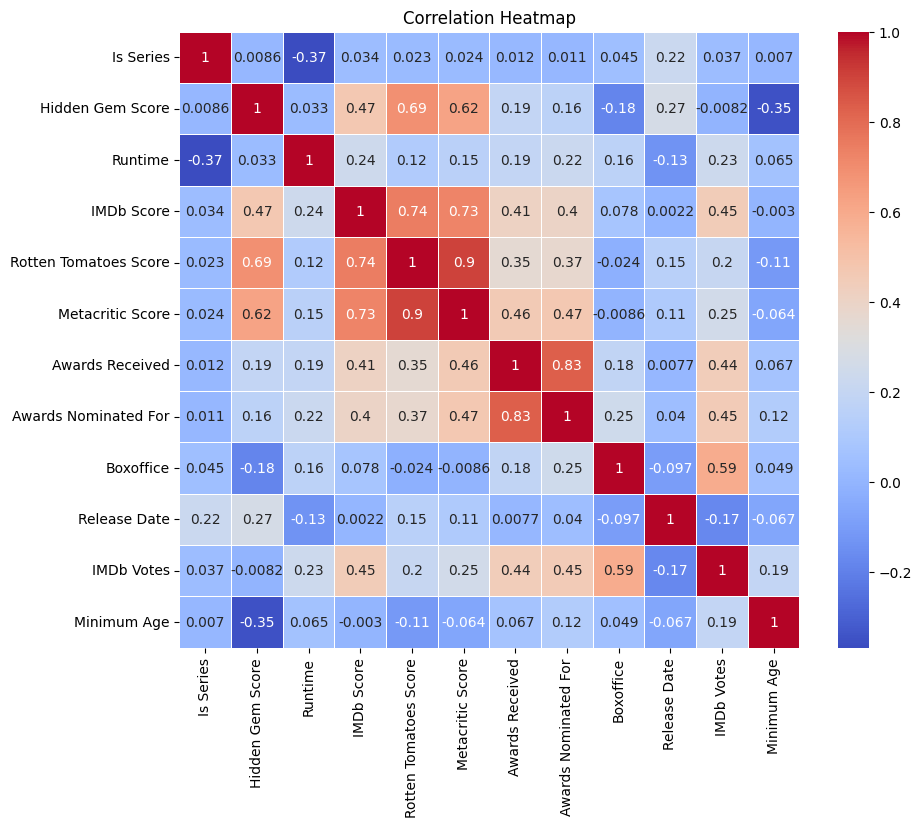

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_data = df.select_dtypes(include=[float, int])

# Create a correlation matrix
corr_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [16]:


genre_one_hot = df['Genre'].str.split(',').apply(lambda x: [item.strip() for item in x])
onehot_encoded = genre_one_hot.explode().str.get_dummies().groupby(level=0).sum()
df = pd.concat([df, onehot_encoded], axis=1)

df = df.drop('Genre', axis=1)

onehot_encoded

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
16,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
17,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15456,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
15457,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
15459,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
15460,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0


In [17]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the numeric data
scaled_numeric_data = scaler.fit_transform(numeric_data)

# Convert the scaled data back to a DataFrame
scaled_numeric_data = pd.DataFrame(scaled_numeric_data, columns=numeric_data.columns)

scaled_numeric_data

,Is Series,Hidden Gem Score,Runtime,IMDb Score,Rotten Tomatoes Score,Metacritic Score,Awards Received,Awards Nominated For,Boxoffice,Release Date,IMDb Votes,Minimum Age
0,1.0,0.430233,0.0,0.818182,0.98,0.808511,0.244147,0.160563,0.003218,1.000000,0.087399,0.944444
1,0.0,0.744186,0.5,0.545455,0.79,0.670213,0.000000,0.000000,0.000106,1.000000,0.001126,0.944444
2,0.0,0.337209,0.5,0.883117,0.68,0.563830,0.371237,0.642254,0.508749,0.999535,0.404310,0.944444
3,0.0,0.255814,0.5,0.636364,0.52,0.478723,0.083612,0.194366,0.719700,0.999535,0.311447,0.555556
4,0.0,0.441860,0.5,0.844156,0.96,0.840426,0.150502,0.264789,0.578450,0.999535,0.325575,0.722222
...,...,...,...,...,...,...,...,...,...,...,...,...
2504,0.0,0.244186,0.5,0.675325,0.45,0.446809,0.016722,0.028169,0.183370,0.000000,0.139221,0.722222
2505,0.0,0.220930,1.0,0.675325,0.36,0.446809,0.000000,0.014085,0.123087,0.000000,0.097769,0.722222
2506,0.0,0.279070,0.5,0.675325,0.63,0.489362,0.006689,0.014085,0.000153,0.000000,0.004821,0.722222
2507,0.0,0.162791,1.0,0.428571,0.25,0.414894,0.033445,0.061972,0.426603,0.000000,0.095235,0.722222


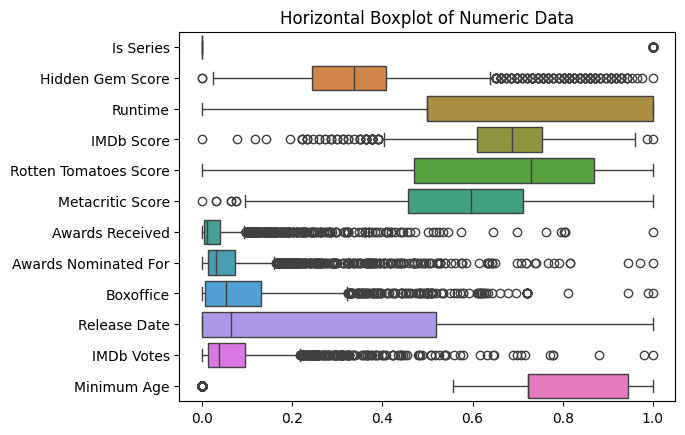

In [18]:

# Create a horizontal boxplot for the numeric data
sns.boxplot(data=scaled_numeric_data, orient='h')
plt.title('Horizontal Boxplot of Numeric Data')
plt.show()

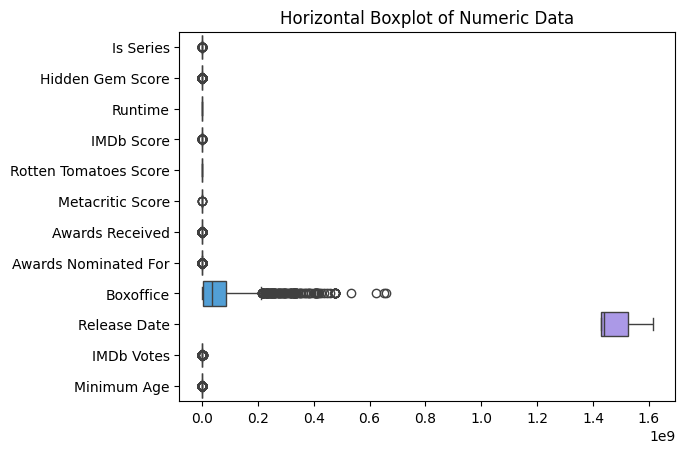

In [19]:


# Create a horizontal boxplot for the numeric data
sns.boxplot(data=numeric_data, orient='h')
plt.title('Horizontal Boxplot of Numeric Data')
plt.show()


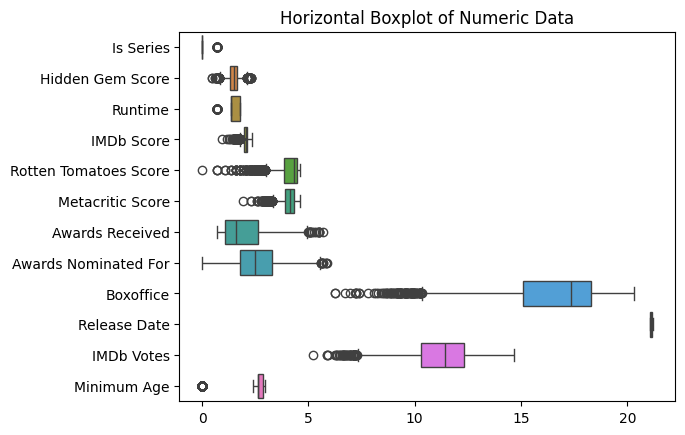

In [20]:
votes = np.log1p(numeric_data)
sns.boxplot(data=votes, orient='h')
plt.title('Horizontal Boxplot of Numeric Data')
plt.show()

In [21]:
# Select only string columns
string_columns = df.select_dtypes(include=[object])

# Print the string columns
string_columns

,Title
0,Lets Fight Ghost
1,HOW TO BUILD A GIRL
15,Joker
16,I
17,Harrys Daughters
...,...
15456,50 First Dates
15457,21
15459,One Chance
15460,The Twilight Saga: Breaking Dawn: Part 1


In [22]:
df.to_csv('preped.csv', index=False)